# Function Calling

To let LLM suggest what function to call based off function definitions

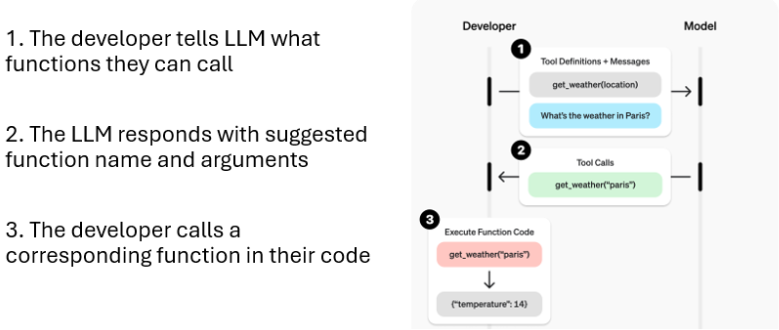

In [4]:
import os

import azure.identity
import openai
from dotenv import load_dotenv

load_dotenv(override=True)
API_HOST = os.getenv("API_HOST", "github")

client = openai.OpenAI(
    base_url="https://models.github.ai/inference",
    api_key=os.environ["GITHUB_TOKEN"],
)

MODEL_NAME = os.getenv("GITHUB_MODEL", "openai/gpt-4o")
print(f"Model: {MODEL_NAME} on Host: {API_HOST}\n")

Model: openai/gpt-4o on Host: github



#### 1. Tell LLM what functions it can call

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_weather",
            "description": "Lookup the weather for a given city name or zip code.",
            "parameters": {
                "type": "object",
                "properties": {
                    "city_name": {
                        "type": "string",
                        "description": "The city name",
                    },
                    "zip_code": {
                        "type": "string",
                        "description": "The zip code",
                    },
                },
                "strict": True, # add strict mode to avoid hallucinations
                "additionalProperties": False,
            },
        },
    }
]

In [ ]:
response = client.chat.completions.create(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "You are a weather chatbot."},
        {"role": "user", "content": "Hi, whats the weather like in berkeley?"},
    ],
    tools=tools,
)

#### 2. Get function name and args from response

In [ ]:
print(f"Response from {MODEL_NAME} on {API_HOST}: \n")

if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    print(tool_call.function.name)
    print(tool_call.function.arguments)
else:
    print(response.choices[0].message.content)

#### 3. Call a local function based on response

In [11]:
import json

In [ ]:
def lookup_weather(city_name=None, zip_code=None):
    """Lookup the weather for a given city name or zip code."""
    print(f"Looking up weather for {city_name or zip_code}...")
    return "It's sunny!"

In [ ]:
response = client.chat.completions.create(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "You are a weather chatbot."},
        {"role": "user", "content": "is it sunny in berkeley CA?"},
    ],
    tools=tools,
    tool_choice="auto",
)

In [ ]:
# Now actually call the function as indicated
if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    function_name = tool_call.function.name
    arguments = json.loads(tool_call.function.arguments)
    if function_name == "lookup_weather":
        lookup_weather(**arguments)
else:
    print(response.choices[0].message.content)

## Extended flow: Sending function results to LLM
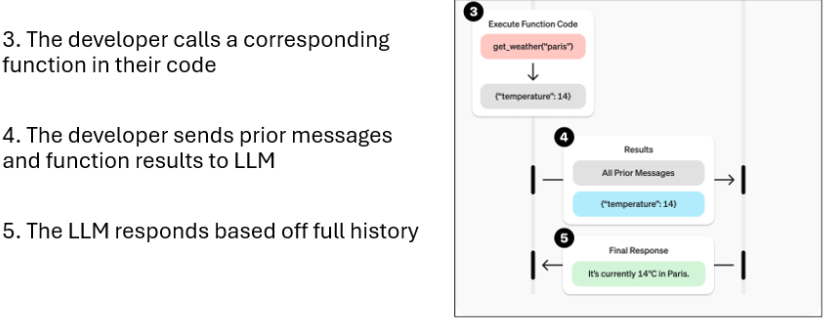

#### 4. Send function results to LLM for final answer

In [ ]:
messages = [
    {"role": "system", "content": "You are a weather chatbot."},
    {"role": "user", "content": "is it sunny in berkeley CA?"},
]

In [ ]:
if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    function_name = tool_call.function.name
    arguments = json.loads(tool_call.function.arguments)

    if function_name == "lookup_weather":
        messages.append(response.choices[0].message)
        result = lookup_weather(**arguments)
        messages.append({"role": "tool", "tool_call_id": tool_call.id, "content": str(result)})
        response = client.chat.completions.create(model=MODEL_NAME, messages=messages, tools=tools)
        print(response.choices[0].message.content)

## Multiple tools

1. Parallel tool calling
2. Tool calling in a loop

### Parallel tool calling

In [12]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_weather",
            "description": "Lookup the weather for a given city name or zip code.",
            "parameters": {
                "type": "object",
                "properties": {
                    "city_name": {
                        "type": "string",
                        "description": "The city name",
                    },
                    "zip_code": {
                        "type": "string",
                        "description": "The zip code",
                    },
                },
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "lookup_movies",
            "description": "Lookup movies playing in a given city name or zip code.",
            "parameters": {
                "type": "object",
                "properties": {
                    "city_name": {
                        "type": "string",
                        "description": "The city name",
                    },
                    "zip_code": {
                        "type": "string",
                        "description": "The zip code",
                    },
                },
                "additionalProperties": False,
            },
        },
    },
]


In [ ]:
# Tool (function) implementations

def lookup_weather(city_name: str | None = None, zip_code: str | None = None) -> str:
    """Looks up the weather for given city_name and zip_code."""
    location = city_name or zip_code or "unknown"
    # In a real implementation, call an external weather API here.
    return {
        "location": location,
        "condition": "rain showers",
        "rain_mm_last_24h": 7,
        "recommendation": "Good day for indoor activities if you dislike drizzle.",
    }


def lookup_movies(city_name: str | None = None, zip_code: str | None = None) -> str:
    """Returns a list of movies playing in the given location."""
    location = city_name or zip_code or "unknown"
    # A real implementation could query a cinema listings API.
    return {
        "location": location,
        "movies": [
            {"title": "The Quantum Reef", "rating": "PG-13"},
            {"title": "Storm Over Harbour Bay", "rating": "PG"},
            {"title": "Midnight Koala", "rating": "R"},
        ],
    }


In [ ]:
messages = [
    {"role": "system", "content": "You are a tourism chatbot."},
    {"role": "user", "content": "is it rainy enough in sydney to watch movies and which ones are on?"},
]
response = client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    tools=tools,
    tool_choice="auto",
)

In [ ]:
print(f"Response from {MODEL_NAME} on {API_HOST}: \n")

# Map function names to actual functions
available_functions = {
    "lookup_weather": lookup_weather,
    "lookup_movies": lookup_movies,
}

# Execute all tool calls in parallel using ThreadPoolExecutor
if response.choices[0].message.tool_calls:
    tool_calls = response.choices[0].message.tool_calls
    print(f"Model requested {len(tool_calls)} tool call(s):\n")

    # Add the assistant's message (with tool calls) to the conversation
    messages.append(response.choices[0].message)

    with ThreadPoolExecutor() as executor:
        # Submit all tool calls to the thread pool
        futures = []
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)
            print(f"Tool request: {function_name}({arguments})")

            if function_name in available_functions:
                future = executor.submit(available_functions[function_name], **arguments)
                futures.append((tool_call, function_name, future))

        # Add each tool result to the conversation
        for tool_call, function_name, future in futures:
            result = future.result()
            messages.append({"role": "tool", "tool_call_id": tool_call.id, "content": json.dumps(result)})

    # Get final response from the model with all tool results
    final_response = client.chat.completions.create(model=MODEL_NAME, messages=messages, tools=tools)
    print("Assistant:")
    print(final_response.choices[0].message.content)
else:
    print(response.choices[0].message.content)

### Tool calling in a loop

In [ ]:
print(f"Model: {MODEL_NAME} on Host: {API_HOST}\n")

while True:
    print("Calling model...\n")
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,  # includes prior tool outputs
        tools=tools,
        tool_choice="auto",
        parallel_tool_calls=False,  # ensure sequential tool calls
    )

    assistant_message = response.choices[0].message
    # If the assistant returned standard content with no tool calls, we're done.
    if not assistant_message.tool_calls:
        print("Assistant:")
        print(assistant_message.content)
        break

    # Append the assistant tool request message to conversation
    messages.append(
        {
            "role": "assistant",
            "content": assistant_message.content or "",
            "tool_calls": [tc.model_dump() for tc in assistant_message.tool_calls],
        }
    )

    # Execute each requested tool sequentially.
    for tool_call in assistant_message.tool_calls:
        fn_name = tool_call.function.name
        raw_args = tool_call.function.arguments or "{}"
        print(f"Tool request: {fn_name}({raw_args})")
        target_tool = available_functions.get(fn_name)
        parsed_args = json.loads(raw_args)
        tool_result = target_tool(**parsed_args)
        tool_result_str = json.dumps(tool_result)
        # Provide the tool output back to the model
        messages.append(
            {
                "role": "tool",
                "tool_call_id": tool_call.id,
                "name": fn_name,
                "content": tool_result_str,
            }
        )

Models can hallucinate function names/arguments
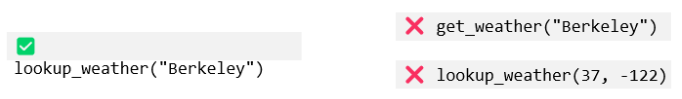

1. Use **"strict": True** (for openAI models only) 
2. Error handling (for other models)

## Error handling

In [6]:
from collections.abc import Callable
from typing import Any

In [7]:
load_dotenv(override=True)
API_HOST = "ollama"
os.environ["API_HOST"] = API_HOST

client = openai.OpenAI(base_url=os.environ["OLLAMA_ENDPOINT"], api_key="nokeyneeded")
MODEL_NAME = os.environ["OLLAMA_MODEL"]

print(f"Model: {MODEL_NAME} on Host: {API_HOST}\n")

Model: llama3.1:latest on Host: ollama



In [8]:
def search_database(search_query: str, price_filter: dict | None = None) -> dict[str, str]:
    """Search database for relevant products based on user query"""
    if not search_query:
        raise ValueError("search_query is required")
    if price_filter:
        if "comparison_operator" not in price_filter or "value" not in price_filter:
            raise ValueError("Both comparison_operator and value are required in price_filter")
        if price_filter["comparison_operator"] not in {">", "<", ">=", "<=", "="}:
            raise ValueError("Invalid comparison_operator in price_filter")
        if not isinstance(price_filter["value"], int | float):
            raise ValueError("Value in price_filter must be a number")
    return [{"id": "123", "name": "Example Product", "price": 19.99}]


tool_mapping: dict[str, Callable[..., Any]] = {
    "search_database": search_database,
}

In [9]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "search_database",
            "description": "Search database for relevant products based on user query",
            "parameters": {
                "type": "object",
                "properties": {
                    "search_query": {
                        "type": "string",
                        "description": "Query string to use for full text search, e.g. 'red shoes'",
                    },
                    "price_filter": {
                        "type": "object",
                        "description": "Filter search results based on price of the product",
                        "properties": {
                            "comparison_operator": {
                                "type": "string",
                                "description": "Operator to compare the column value, either '>', '<', '>=', '<=', '='",  # noqa
                            },
                            "value": {
                                "type": "number",
                                "description": "Value to compare against, e.g. 30",
                            },
                        },
                    },
                },
                "required": ["search_query"],
            },
        },
    }
]

In [13]:
messages: list[dict[str, Any]] = [
    {"role": "system", "content": "You are a product search assistant."},
    {"role": "user", "content": "Find me a red shirt under $20."},
]

print(f"Model: {MODEL_NAME} on Host: {API_HOST}\n")

# First model response (may include tool call)
response = client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    tools=tools,
    tool_choice="auto",
    parallel_tool_calls=False,
)

assistant_msg = response.choices[0].message

# If no tool calls were requested, just print the answer.
if not assistant_msg.tool_calls:
    print("Assistant:")
    print(assistant_msg.content)
else:
    # Append assistant message including tool call metadata
    messages.append(
        {
            "role": "assistant",
            "content": assistant_msg.content or "",
            "tool_calls": [tc.model_dump() for tc in assistant_msg.tool_calls],
        }
    )

    # Process each requested tool sequentially (though usually one here)
    for tool_call in assistant_msg.tool_calls:
        fn_name = tool_call.function.name
        raw_args = tool_call.function.arguments or "{}"
        print(f"Tool request: {fn_name}({raw_args})")

        target = tool_mapping.get(fn_name)
        if not target:
            tool_result: Any = f"ERROR: No implementation registered for tool '{fn_name}'"
        else:
            # Parse arguments safely
            try:
                parsed_args = json.loads(raw_args) if raw_args.strip() else {}
            except json.JSONDecodeError:
                parsed_args = {}
                tool_result = "Warning: Malformed JSON arguments received; proceeding with empty args"
            else:
                try:
                    tool_result = target(**parsed_args)
                except Exception as e:  # safeguard tool execution
                    tool_result = f"Tool execution error in {fn_name}: {e}"

        # Serialize tool output (dict or str) as JSON string for the model
        try:
            tool_content = json.dumps(tool_result)
        except Exception:
            # Fallback to string conversion if something isn't JSON serializable
            tool_content = json.dumps({"result": str(tool_result)})

        messages.append(
            {
                "role": "tool",
                "tool_call_id": tool_call.id,
                "name": fn_name,
                "content": tool_content,
            }
        )

    # Follow-up model response after supplying tool outputs
    followup = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
        tools=tools,
    )
    final_msg = followup.choices[0].message
    print("Assistant (final):")
    print(final_msg.content)

Model: llama3.1:latest on Host: ollama

Tool request: search_database({"search_query":"red shirt","price_filter":{"comparison_operator":"=","value":20}})
Assistant (final):
We found a red shirt that meets your requirements! The product is called "Example Product" and its price is $19.99, which is under your budget of $20. If you're interested in purchasing this product, we can provide more information or help with the checkout process. Would you like to proceed?


## "Few-shot" examples of tool calls

show examples with correct arguments

In [16]:
messages: list[dict[str, Any]] = [
    {"role": "system", "content": "You are a product search assistant."},
    {"role": "user", "content": "good options for climbing gear that can be used outside?"},
    {
        "role": "assistant",
        "content": "",
        "tool_calls": [
            {
                "id": "call_abc123",
                "type": "function",
                "function": {"name": "search_database", "arguments": '{"search_query":"climbing gear outside"}'},
            }
        ],
    },
    {
        "role": "tool",
        "tool_call_id": "call_abc123",
        "name": "search_database",
        "content": "Search results for climbing gear that can be used outside: ...",
    },
    {"role": "user", "content": "are there any shoes less than $50?"},
    {
        "role": "assistant",
        "content": "",
        "tool_calls": [
            {
                "id": "call_abc456",
                "type": "function",
                "function": {
                    "name": "search_database",
                    "arguments": '{"search_query":"tenis","price_filter":{"comparison_operator":"<","value":50}}',
                },
            }
        ],
    },
    {
        "role": "tool",
        "tool_call_id": "call_abc456",
        "name": "search_database",
        "content": "Search results for shoes cheaper than 50: ...",
    },
    {"role": "user", "content": "Find me a red shirt under $20."},
]

In [15]:
print(f"Model: {MODEL_NAME} on Host: {API_HOST}\n")

# First model response (may include tool call)
response = client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    tools=tools,
    tool_choice="auto",
    parallel_tool_calls=False,
)

assistant_msg = response.choices[0].message

# If no tool calls were requested, just print the answer.
if not assistant_msg.tool_calls:
    print("Assistant:")
    print(assistant_msg.content)
else:
    # Append assistant message including tool call metadata
    messages.append(
        {
            "role": "assistant",
            "content": assistant_msg.content or "",
            "tool_calls": [tc.model_dump() for tc in assistant_msg.tool_calls],
        }
    )

    # Process each requested tool sequentially (though usually one here)
    for tool_call in assistant_msg.tool_calls:
        fn_name = tool_call.function.name
        raw_args = tool_call.function.arguments or "{}"
        print(f"Tool request: {fn_name}({raw_args})")

        target = tool_mapping.get(fn_name)
        if not target:
            tool_result: Any = f"ERROR: No implementation registered for tool '{fn_name}'"
        else:
            # Parse arguments safely
            try:
                parsed_args = json.loads(raw_args) if raw_args.strip() else {}
            except json.JSONDecodeError:
                parsed_args = {}
                tool_result = "Warning: Malformed JSON arguments received; proceeding with empty args"
            else:
                try:
                    tool_result = target(**parsed_args)
                except Exception as e:  # safeguard tool execution
                    tool_result = f"Tool execution error in {fn_name}: {e}"

        # Serialize tool output (dict or str) as JSON string for the model
        try:
            tool_content = json.dumps(tool_result)
        except Exception:
            # Fallback to string conversion if something isn't JSON serializable
            tool_content = json.dumps({"result": str(tool_result)})

        messages.append(
            {
                "role": "tool",
                "tool_call_id": tool_call.id,
                "name": fn_name,
                "content": tool_content,
            }
        )

    # Follow-up model response after supplying tool outputs
    followup = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
        tools=tools,
    )
    final_msg = followup.choices[0].message
    print("Assistant (final):")
    print(final_msg.content)

Model: llama3.1:latest on Host: ollama

Tool request: search_database({"price_filter":{"comparison_operator":"\u003c","value":20},"search_query":"red shirt"})
Assistant (final):
I found a red shirt for $19.99 that fits your budget and search criteria. 

Name: Example Product
Price: 19.99
Id: 123 

Please check the product's details before finalizing your purchase.
